# Unity ML-Agents Toolkit
## Environment Basics
https://github.com/Unity-Technologies/ml-agents/blob/e82450ab8304093871fd19b876a0f819d390e79d/notebooks/getting-started-gym.ipynb

### 1. Set environment parameters

Be sure to set `env_name` to the name of the Unity environment file you want to launch. Ensure that the environment build is in the `python/` directory.

In [2]:
#pip install keras-rl
#pip install gym_unity

import sys

print("Python version:")
print(sys.version)
print(sys.version_info[0])

Python version:
3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
3


### 2. Load dependencies

The following loads the necessary dependencies and checks the Python version (at runtime). ML-Agents Toolkit (v0.3 onwards) requires Python 3.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from unityagents import UnityEnvironment

%matplotlib inline

print("Python version:")
print(sys.version)

# check Python version
if (sys.version_info[0] < 3):
    raise Exception("ERROR: ML-Agents Toolkit (v0.3 onwards) requires Python 3")

AttributeError: module 'numpy' has no attribute 'square'

In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

INPUT_SHAPE = (512, 512)
WINDOW_LENGTH = 4
ACTIONS_LENGTH = 8
cnn_kernel_count = 40

input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

model = Sequential()


input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

frame_in = Input(shape=input_shape)

if K.image_dim_ordering() == 'tf':
    # (width, height, channels)
    x = Permute((2, 3, 1))(frame_in)
elif K.image_dim_ordering() == 'th':
    # (channels, width, height)
    x = Permute((1, 2, 3))(frame_in)

x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = MaxPooling2D((2, 2))(x)


x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = MaxPooling2D((2, 2))(x)


x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = MaxPooling2D((2, 2))(x)


x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = MaxPooling2D((2, 2))(x)


x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = MaxPooling2D((2, 2))(x)



x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = MaxPooling2D((2, 2))(x)



x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(ACTIONS_LENGTH, activation='linear')(x)


model = Model([frame_in], [predictions])

print(model.summary())


In [ ]:
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!

import pprint as pp
from PIL import *
import PIL.Image

class FoosProcessor(Processor):
    def process_observation(self, observation):
        data = np.array(observation, dtype="float32")
        data = data[0,0,:,:,:]
        data = (data * 255 / 1.0).astype('uint8')
        
        
        assert data.ndim == 3  # (height, width, channel)
        
        img = Image.fromarray(data)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)



memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = FoosProcessor()


# Select a policy. We use eps-greedy action selection, which means that a random action is selected
# with probability eps. We anneal eps from 1.0 to 0.1 over the course of 1M steps. This is done so that
# the agent initially explores the environment (high eps) and then gradually sticks to what it knows
# (low eps). We also set a dedicated eps value that is used during testing. Note that we set it to 0.05
# so that the agent still performs some random actions. This ensures that the agent cannot get stuck.
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)


agent = DQNAgent(model=model, nb_actions=ACTIONS_LENGTH, policy=policy, memory=memory,
              processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

agent.compile(Adam(lr=.00025), metrics=['mae'])

### 3. Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# Name of the Unity environment binary to launch
from gym_unity.envs import UnityEnv
env_name = "FoosRLBuild\\FoosRLBuild"  # Name of the Unity environment binary to launch
env = UnityEnv(env_name, worker_id=1, 
                     use_visual=True, multiagent=True)

# Examine environment parameters
print(str(env))



### 4. Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

In [ ]:
# Reset the environment
initial_observations = env.reset()

if len(env.observation_space.shape) == 1:
    # Examine the initial vector observation
    print("Agent observations look like: \n{}".format(initial_observations[0]))
else:
    # Examine the initial visual observation
    print("Agent observations look like:")
    if env.observation_space.shape[2] == 3:
        plt.imshow(initial_observations[0][:,:,:])
    else:
        plt.imshow(initial_observations[0][:,:,0])

(1, 2, 512, 512, 3)
Agent observations look like:


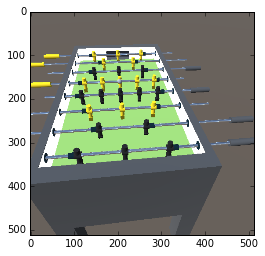

In [6]:

# Reset the environment
initial_observation = env.reset()
data = np.array(initial_observation)
pp.pprint(data.shape)

if len(env.observation_space.shape) == 1:
    # Examine the initial vector observation
    print("Agent state looks like: \n{}".format(initial_observation))
else:
    # Examine the initial visual observation
    print("Agent observations look like:")
    if env.observation_space.shape[2] == 3:
        plt.imshow(data[0,0,:,:,:])
    else:
        plt.imshow(initial_observation[:,:,0])



In [15]:
# Okay, now it's time to learn something! We capture the interrupt exception so that training
# can be prematurely aborted. Notice that you can the built-in Keras callbacks!
weights_filename = 'dqn_{}_weights.h5f'.format("foosrl")
checkpoint_weights_filename = 'dqn_foosrl_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format("foosrl")
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
agent.fit(env, callbacks=callbacks, nb_steps=1750, log_interval=100)


# After training is done, we save the final weights one more time.
agent.save_weights(weights_filename, overwrite=True)


# Finally, evaluate our algorithm for 10 episodes.
agent.test(env, nb_episodes=10, visualize=False)

Training for 1750000 steps ...
array([[[106,  99,  94],
        [106,  99,  94],
        [106,  99,  94],
        ...,
        [106,  99,  95],
        [106,  99,  95],
        [106,  99,  95]],

       [[106,  99,  94],
        [106,  99,  94],
        [106,  99,  94],
        ...,
        [106,  99,  95],
        [106,  99,  95],
        [106,  99,  95]],

       [[106,  99,  94],
        [106,  99,  94],
        [106,  99,  94],
        ...,
        [106,  99,  95],
        [106,  99,  95],
        [106,  99,  95]],

       ...,

       [[104,  97,  91],
        [104,  97,  91],
        [104,  97,  91],
        ...,
        [104,  97,  91],
        [104,  97,  91],
        [104,  97,  91]],

       [[104,  97,  91],
        [104,  97,  91],
        [104,  97,  91],
        ...,
        [104,  97,  91],
        [104,  97,  91],
        [104,  97,  91]],

       [[104,  97,  91],
        [104,  97,  91],
        [104,  97,  91],
        ...,
        [104,  97,  91],
        [104,  97,

UnityGymException: The environment was expecting `action` to be a list.

### 5. Take random actions in the environment
Once we restart an environment, we can step the environment forward and provide actions to all of the agents within the environment. Here we simply choose random actions based on the `action_space_type` of the default brain. 

Once this cell is executed, 10 messages will be printed that detail how much reward will be accumulated for the next 10 episodes. The Unity environment will then pause, waiting for further signals telling it what to do next. Thus, not seeing any animation is expected when running this cell.

In [ ]:
for episode in range(10):
    env_info = env.reset(train_mode=train_mode)[default_brain]
    done = False
    episode_rewards = 0
    while not done:
        if brain.vector_action_space_type == 'continuous':
            env_info = env.step(np.random.randn(len(env_info.agents), 
                                                brain.vector_action_space_size))[default_brain]
        else:
            env_info = env.step(np.random.randint(0, brain.vector_action_space_size, 
                                                  size=(len(env_info.agents))))[default_brain]
        episode_rewards += env_info.rewards[0]
        done = env_info.local_done[0]
    print("Total reward this episode: {}".format(episode_rewards))

### 6. Close the environment when finished
When we are finished using an environment, we can close it with the function below.

In [ ]:
env.close()